In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from scipy.stats import pearsonr
from tqdm import tqdm
import timeit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

Input data:  
- CCLE_expression.csv  
Gene expression TPM (transcript per million) values of the protein coding genes for DepMap cell lines  
log2(TPM+1) goes from 0.00 to 17.78


- CRISPR_gene_effect.csv
Gene effect of the protein coding genes for DepMap cell lines
Gene Effect scores derived from CRISPR knockout screens published by Broad’s Achilles and Sanger’s SCORE projects.  
Negative scores imply cell growth inhibition and/or death following gene knockout. Scores are normalized such that nonessential genes have a median score of 0 and independently identified common essentials have a median score of -1.
SCORE goes from -3.89 to 2.73. 

- preprocess/index_to_protein_and_gene.txt

- preprocess/adjacence_matrix.txt

Genes:16,481  
Cell Lines:1,081  
Primary Diseases:31 (?)  
Lineages:28 (?)

## Retrieve data 

In [233]:
gene_expression = pd.read_csv('preprocess/gene_expression.csv').set_index('DepMap')
gene_effect = pd.read_csv('preprocess/gene_effect.csv').set_index('DepMap')

In [235]:
print(gene_expression.shape)
print(gene_effect.shape)

(1001, 16481)
(1001, 16481)


In [3]:
protein_info = pd.read_csv('preprocess/index_to_protein_and_gene.txt', header=None, sep=' ')
protein_info = protein_info.rename(columns={0:'index', 1:'protein', 2:'gene_ID'})
protein_info = protein_info.set_index('index')

In [4]:
adjacence_matrix = np.loadtxt('preprocess/adjacence_matrix.txt', delimiter=' ', dtype=int)

In [5]:
gene_expression.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,3.116032,0.056584,0.226509,0.111031,0.000000,1.035624,0.176323,5.700440,4.144046,0.790772,...,5.080658,6.675957,0.978196,1.914565,4.700994,3.282440,2.797013,6.821455,3.010780,4.381975
ACH-000002,1.395063,0.000000,0.275007,0.111031,0.000000,0.137504,0.000000,5.078951,1.948601,0.000000,...,3.204767,6.388017,0.097611,1.000000,3.925050,0.000000,1.070389,5.963474,2.169925,3.255501
ACH-000003,1.400538,4.305241,0.321928,0.150560,0.000000,4.219556,0.097611,5.195348,3.962549,1.687061,...,4.013462,7.528181,0.464668,1.555816,2.851999,0.704872,2.316146,7.302867,2.659925,2.748461
ACH-000004,4.178715,0.000000,0.214125,0.344828,0.070389,0.097611,0.000000,6.336819,3.231125,0.000000,...,4.276497,6.098664,0.765535,1.622930,3.619413,0.014355,2.032101,7.002252,3.444932,4.910733
ACH-000005,4.003602,0.014355,0.137504,0.014355,0.000000,0.028569,0.000000,6.337176,3.781360,0.000000,...,5.628482,6.785289,0.807355,1.773996,3.763412,0.014355,2.761285,6.826421,3.524816,5.592457


In [6]:
gene_effect.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921,0.064932,...,-0.037619,-0.116524,-0.029331,0.105940,0.147605,-0.119822,0.063387,0.160857,0.058648,-0.316792
ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372,0.151300,...,-0.030901,-0.262220,0.136406,0.031327,0.093763,-0.079692,-0.173709,0.153632,0.175627,-0.040869
ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871,-0.036037,...,0.039434,-0.336925,-0.095528,-0.035541,-0.035612,-0.040183,-0.165464,0.077343,0.019387,-0.085687
ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998,0.139288,...,-0.229303,-0.463191,0.061641,0.190301,0.119388,-0.036695,-0.182449,-0.146936,-0.189451,-0.281167
ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227,-0.001700,...,-0.157219,-0.318765,0.015761,0.196949,-0.045874,-0.186805,-0.275629,-0.001227,-0.049140,-0.240582


In [7]:
protein_info.head()

,protein,gene_ID
index,,
0,9606.ENSP00000263100,A1BG
1,9606.ENSP00000378868,A1CF
2,9606.ENSP00000323929,A2M
3,9606.ENSP00000299698,A2ML1
4,9606.ENSP00000475261,A3GALT2


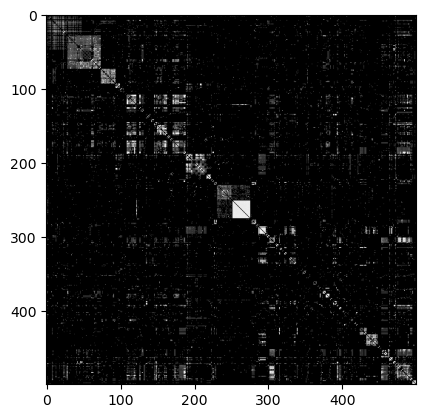

In [8]:
plt.imshow(adjacence_matrix[:500,:500], cmap='gray');plt.show()

## Smooth graph

For node $i$ with value $x_i$, we compute a new value $x_i^*$:
$$x_i^* = \lambda x_i 
+ (1-\lambda) \sum_{j \in \mathcal N(i)}
\Big( \frac {e_{ji}}{\sum_{j \in \mathcal N(i)} e_{ji}} \Big)  x_j$$
where 
$\lambda$ is a parametrization factor, 
$\mathcal N(i)$ is the set of neighbors of node $i$,
$e_{ji}$ is the weight of the edge from node $j$ to node $i$.



In [8]:
def smoothen(x, lamb, adjacence_matrix):
    new_x = x * 0
    for i in range(len(x)):  # rmk: can be written as a matrix product
        alphas = adjacence_matrix[i]
        new_x[i] = lamb * x[i] + (1-lamb) * alphas.dot(cl_expression) / np.sum(alphas)
    return new_x

### Compare lambda coefficient

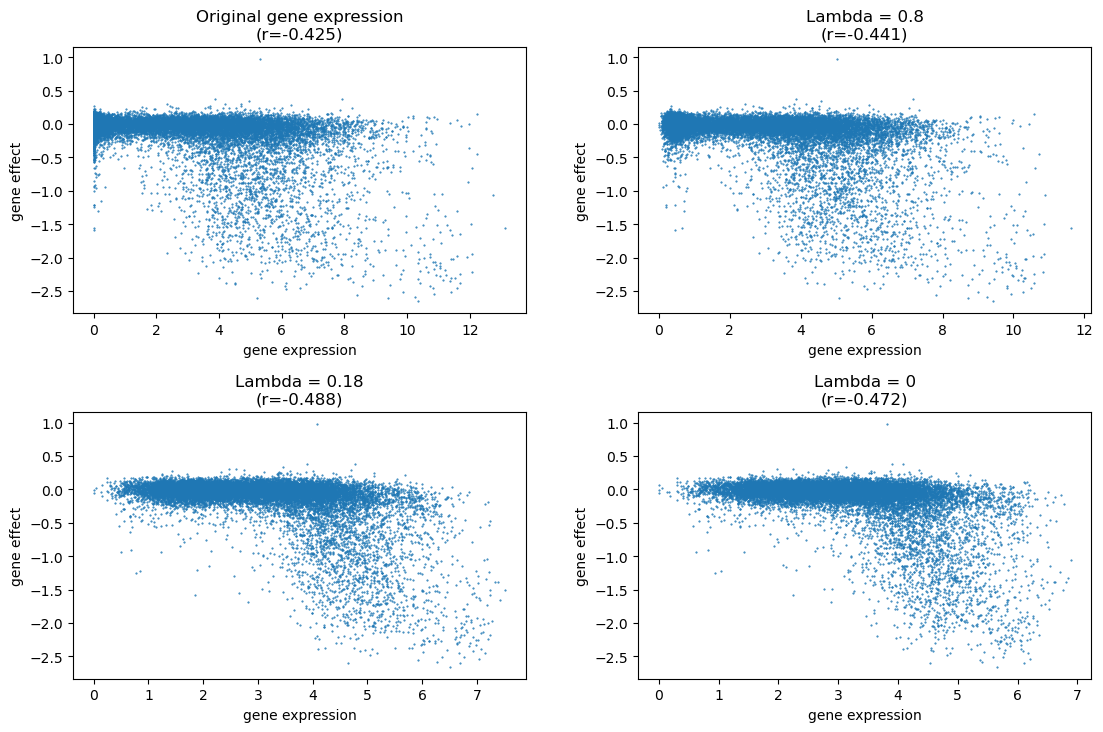

CPU times: user 42.5 s, sys: 4.3 s, total: 46.8 s
Wall time: 43.2 s


In [322]:
%%time
fig_width = 6
fig_height = 4
nb_i, nb_j = 2,2

lambs = [0.8, 0.18, 0]
cell_lines = [253]

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()
for cell_line in cell_lines:
    pearson_coeff = pearsonr(gene_expression.iloc[cell_line], gene_effect.iloc[cell_line]).statistic
    axs[0].scatter(gene_expression.iloc[cell_line], 
                   gene_effect.iloc[cell_line], 
                   marker='.', s=1)
axs[0].set_title(f'Original gene expression\n(r={pearson_coeff:.3f})')

for lamb_idx, lamb in enumerate(lambs):
    xx_expression = []
    yy_effect = []
    for cell_line in cell_lines:
        cl_expression = gene_expression.iloc[cell_line]
        new_cl_expression = smoothen(cl_expression, lamb, adjacence_matrix)
        
        xx_expression.append(new_cl_expression)
        yy_effect.append(gene_effect.iloc[cell_line])
    
    xx = np.concatenate(xx_expression)
    yy = np.concatenate(yy_effect)
    
    pearson_coeff = pearsonr(xx, yy).statistic

    axs[lamb_idx+1].scatter(xx, yy, marker='.', s=1)
    axs[lamb_idx+1].set_title(f"Lambda = {lamb}\n(r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

### Compare successive smoothing

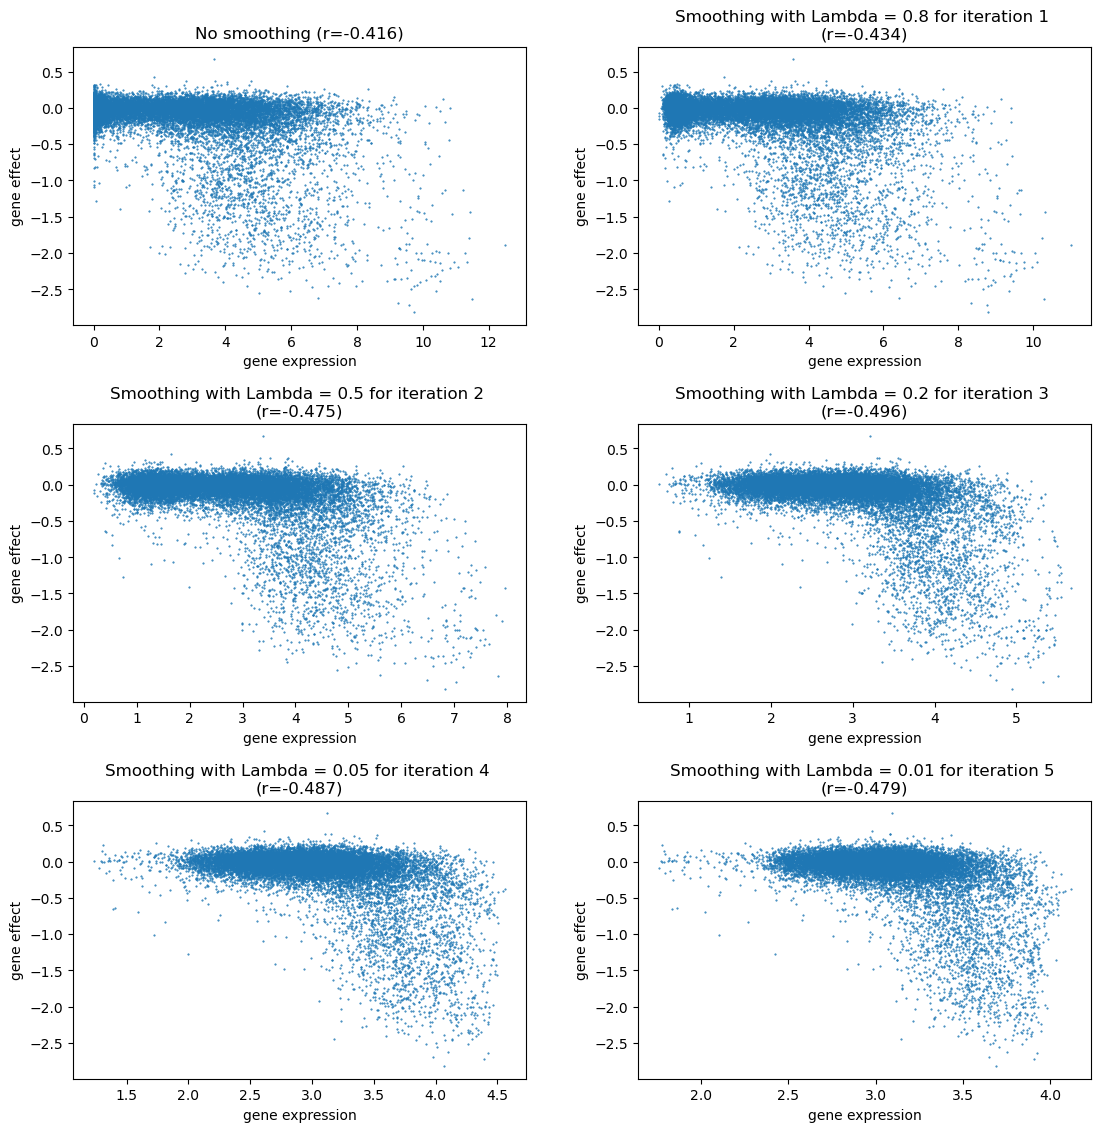

CPU times: user 29.5 s, sys: 707 ms, total: 30.2 s
Wall time: 19.3 s


In [126]:
%%time
fig_width = 6
fig_height = 4
nb_i, nb_j = 3, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

#lambs = [0.5] * 3
lambs = [0.8, 0.5, 0.2, 0.05, 0.01]
cell_line = 253
cl_expression = gene_expression.iloc[cell_line]
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No smoothing (r={pearson_coeff:.3f})')

for smoothing_idx in range(len(lambs)):
    lamb = lambs[smoothing_idx]
    cl_expression = smoothen(cl_expression, lamb, adjacence_matrix)
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    
    axs[smoothing_idx+1].scatter(cl_expression, 
                            gene_effect.iloc[cell_line], 
                            marker='.', s=1)
    #axs[smoothing_idx+1].set_title(f"Smoothing {smoothing_idx+1} times")
    axs[smoothing_idx+1].set_title(f"Smoothing with Lambda = {lamb} for iteration {smoothing_idx+1} "
                                   f"\n(r={pearson_coeff:.3f})")
    

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

### Other types of layer

We define 6 types of layers:

- Summation with normalization 
$$x_i^* = \lambda_1 x_i 
+ \lambda_2 \sum_{j \in \mathcal N(i)}
\Big( \frac {e_{ji}}{\sum_{j \in \mathcal N(i)} e_{ji}} \Big)  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Summation without normalization 
$$x_i^* = \lambda_1 x_i + \lambda_2 \sum_{j \in \mathcal N(i)} e_{ji}  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Mean value with normalization 
$$x_i^* = \lambda_1 x_i 
+ \lambda_2 \frac 1 {|\mathcal N(i)|}\sum_{j \in \mathcal N(i)}
\Big( \frac {e_{ji}}{\sum_{j \in \mathcal N(i)} e_{ji}} \Big)  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Mean value without normalization 
$$x_i^* = \lambda_1 x_i + \lambda_2 \frac 1 {|\mathcal N(i)|}\sum_{j \in \mathcal N(i)} e_{ji}  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Maximum value with normalization 
$$x_i^* = \lambda_1 x_i 
+ \lambda_2 \max_{j \in \mathcal N(i)}
\Big( \frac {e_{ji}}{\sum_{j \in \mathcal N(i)} e_{ji}} \Big)  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Maximum value without normalization 
$$x_i^* = \lambda_1 x_i + \lambda_2 \max_{j \in \mathcal N(i)} e_{ji}  x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$


And 3 more types of layers:

- Summation with unlabeled edges 
$$x_i^* = \lambda_1 x_i 
+ \lambda_2 \sum_{j \in \mathcal N(i)} x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Mean value with unlabeled edges
$$x_i^* = \lambda_1 x_i 
+ \lambda_2 \frac 1 {|\mathcal N(i)|}\sum_{j \in \mathcal N(i)} x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$
- Maximum value with unlabeled edges
$$x_i^* = \lambda_1 x_i 
+ \lambda_2 \max_{j \in \mathcal N(i)} x_j
\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad $$


In [129]:
np.max(np.arange(12).reshape((4,3)) * np.array([1,2,5]), axis=1)

array([10, 25, 40, 55])

In [308]:
edges_sum = np.sum(adjacence_matrix, axis=1)
large_ones = np.ones(adjacence_matrix.shape[1])
    

def graphnn_layer(x, adjacence_matrix, params, aggr='add', normalize=True, bias=None):
    global edges_sum, large_ones
    new_x = x * 0
    
    if (type(params) is list or type(params) is tuple) and len(params) > 1:
        pass
    else:
        params = [params, 1 - params]
    
    norm_factor = edges_sum if normalize else large_ones
    
    if aggr == 'add':
        new_x = params[0] * x + params[1] * (adjacence_matrix @ x) / norm_factor
    elif aggr == 'mean':
        nb_neighbors = np.sum(adjacence_matrix > 0, axis=1)
        new_x = params[0] * x + params[1] * (adjacence_matrix @ x) / (norm_factor * nb_neighbors)
    elif aggr == 'max':
        new_x = params[0] * x + params[1] * np.max(adjacence_matrix * x, axis=1) / (norm_factor)
    else:
        print("Unkown aggregation type", aggr)
    if bias is not None:
        new_x += bias
        
    return new_x

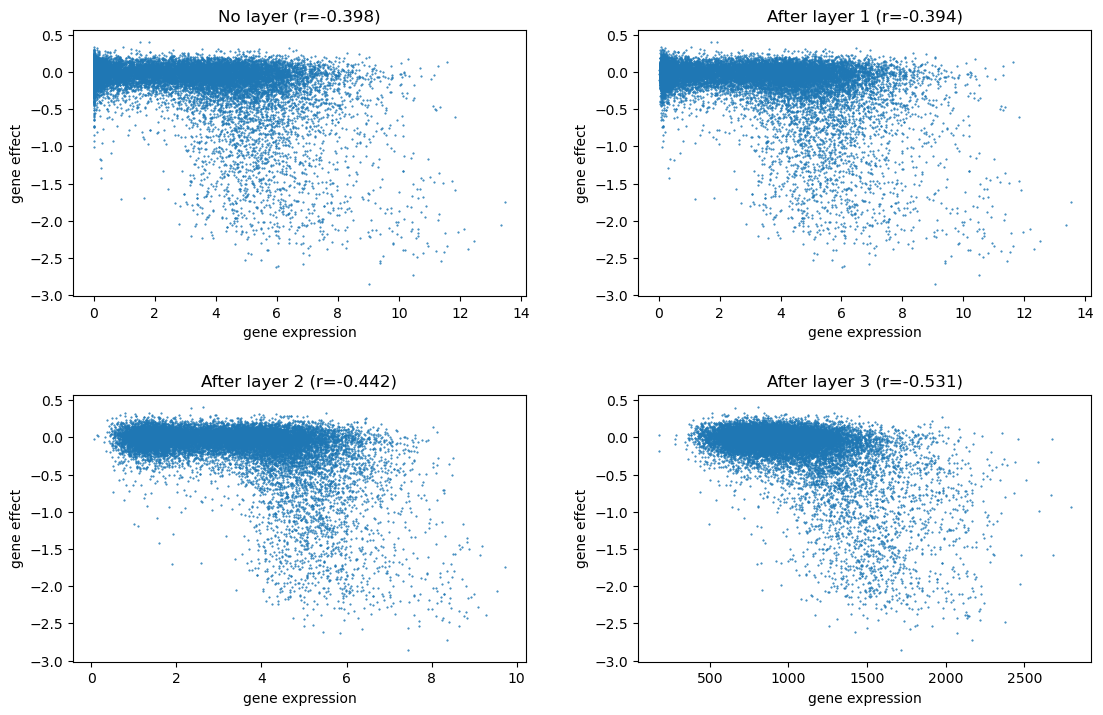

CPU times: user 9.68 s, sys: 6.42 s, total: 16.1 s
Wall time: 22.1 s


In [134]:
%%time
fig_width = 6
fig_height = 4
nb_i, nb_j = 2, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

layers = [
    {'params':0.5, 'aggr':'add'},
    {'params':[1, 0.2], 'aggr':'max'},
    {'params':[0.9, 0.1], 'aggr':'mean', 'normalize':False, 'bias':0.1}
]
layers = [
    {'params':[1,2], 'aggr':'max'},
    {'params':0.5, 'aggr':'add'},
    {'params':[3, 1], 'aggr':'mean', 'normalize':False, 'bias':-2}
]
cell_line = 0
cl_expression = gene_expression.iloc[cell_line].to_numpy()
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No layer (r={pearson_coeff:.3f})')

for i,layer in enumerate(layers):
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)

    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    
    axs[i+1].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i+1].set_title(f"After layer {i+1} (r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

0 -0.4127546455075015
1 -0.4616088127482467
2 -0.5454837776751289


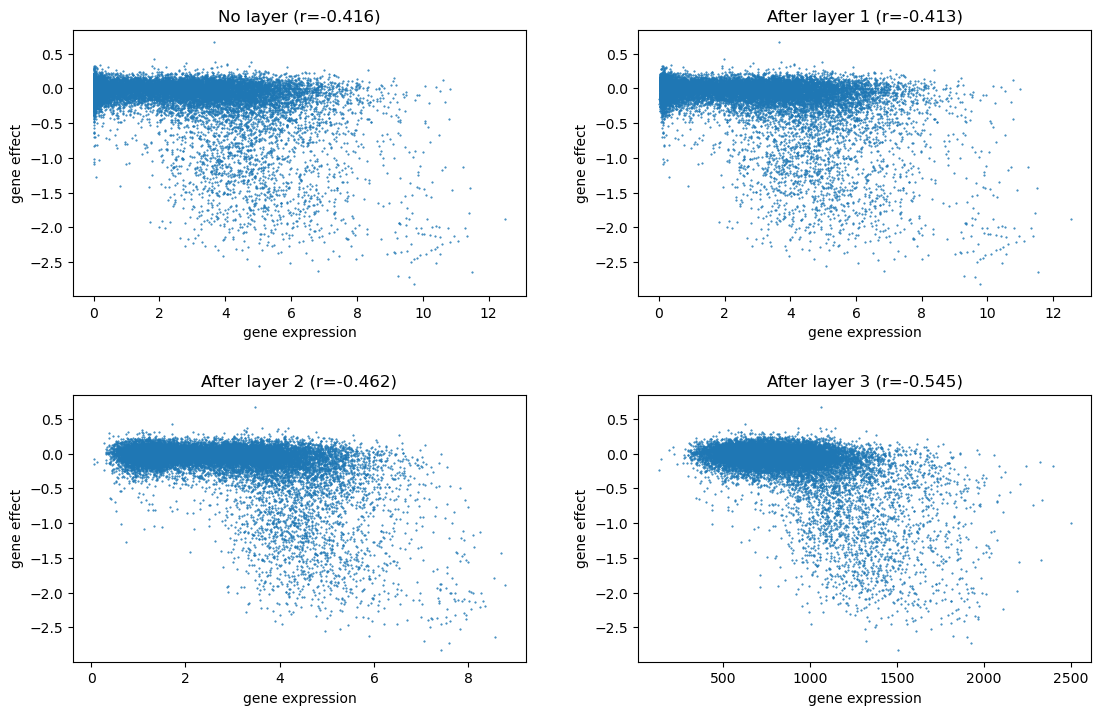

CPU times: user 29.3 s, sys: 765 ms, total: 30.1 s
Wall time: 30.3 s


In [124]:
%%time
fig_width = 6
fig_height = 4

layers = [
    {'params':[1,2], 'aggr':'max'},
    {'params':0.5, 'aggr':'add'},
    {'params':[3, 1], 'aggr':'mean', 'normalize':False, 'bias':-2},
]

nb_i, nb_j = len(layers)//2+1, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

cell_line = 253
cl_expression = gene_expression.iloc[cell_line]
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No layer (r={pearson_coeff:.3f})')

for i,layer in enumerate(layers):
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
    
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    print(i,pearson_coeff)
    axs[i+1].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i+1].set_title(f"After layer {i+1} (r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

0 -0.5430359824213266


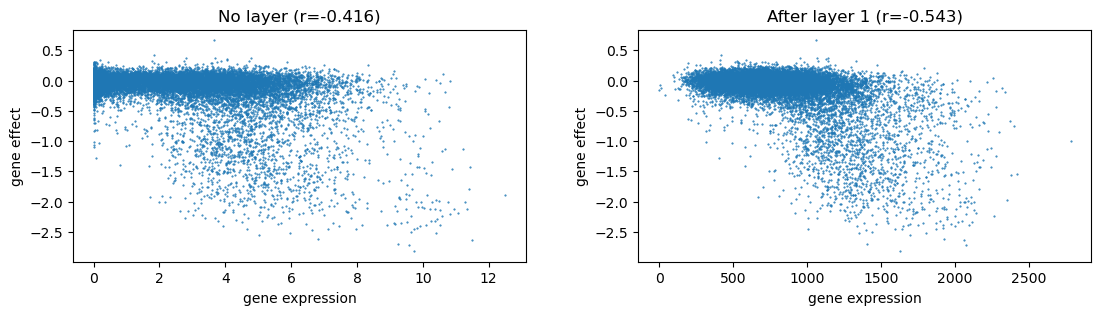

CPU times: user 13.3 s, sys: 203 ms, total: 13.5 s
Wall time: 13.3 s


In [138]:
%%time
fig_width = 6
fig_height = 4

layers = [
    #{'params':[1,2], 'aggr':'max'},
    #{'params':0.5, 'aggr':'add'},
    {'params':[3, 1], 'aggr':'mean', 'normalize':False, 'bias':-2},
]

nb_i, nb_j = len(layers)//2+1, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

cell_line = 253
cl_expression = gene_expression.iloc[cell_line]
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No layer (r={pearson_coeff:.3f})')

for i,layer in enumerate(layers):
    lamb = lambs[smoothing_idx]
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
    
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    print(i,pearson_coeff)
    axs[i+1].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i+1].set_title(f"After layer {i+1} (r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

### Effect of Lambda on smoothing

In [320]:
%%time
lambs = [0.01, 0.05, 0.1, 0.15, 0.18, 0.2, 0.22, 0.25, 0.3, 0.5, 0.8, 1]
cell_line = 253

smooth_pearson_coeffs = []
for lamb in lambs:
    cl_expression = gene_expression.iloc[cell_line]
    cl_expression = smoothen(cl_expression, lamb, adjacence_matrix)
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    smooth_pearson_coeffs.append(pearson_coeff)

CPU times: user 1min 41s, sys: 3.75 s, total: 1min 44s
Wall time: 1min


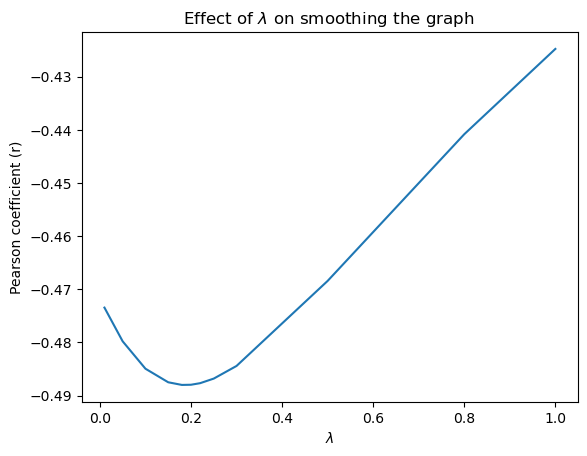

In [321]:
plt.plot(lambs, smooth_pearson_coeffs)
plt.xlabel("$\lambda$")
plt.ylabel("Pearson coefficient (r)")
plt.title('Effect of $\lambda$ on smoothing the graph ')
plt.show()

### Effect of lambda on mean value layer

In [155]:
%%time
#lambs = [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1]
lambs = [0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

cell_line = 253

pearson_coeffs = []
for lamb in lambs:
    #layer = {'params':lamb, 'aggr':'max'}
    layer = {'params':lamb, 'aggr':'mean', 'normalize':False}
    cl_expression = gene_expression.iloc[cell_line]
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    print(lamb, pearson_coeff)
    pearson_coeffs.append(pearson_coeff)

0.9 -0.5445066613358953
0.95 -0.5459507090995303
0.96 -0.5462757569814944
0.97 -0.5463360368529615
0.98 -0.5450671247856217
0.99 -0.5355847800158756
CPU times: user 1min 19s, sys: 2.23 s, total: 1min 22s
Wall time: 1min 27s


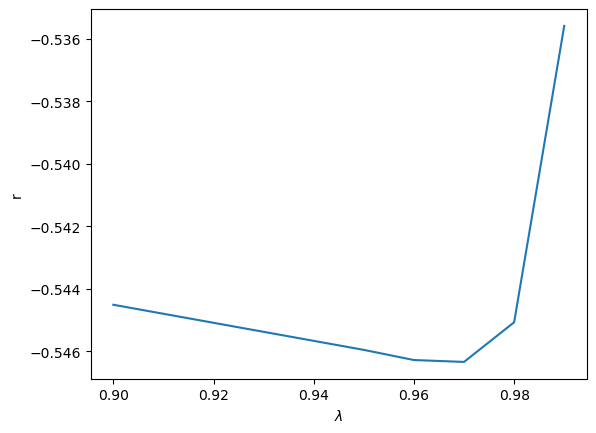

In [156]:
plt.plot(lambs[:], pearson_coeffs[:])
plt.xlabel("$\lambda$")
plt.ylabel("r")
plt.show()

In [ ]:
%%time
fig_width = 6
fig_height = 4

layers = [
    {'params':0.16, 'aggr':'add'},
    {'params':0.97, 'aggr':'mean', 'normalize':False},
]

nb_i, nb_j = len(layers)//2+1, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

cell_line = 253
cl_expression = gene_expression.iloc[cell_line]
pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title(f'No layer (r={pearson_coeff:.3f})')

for i,layer in enumerate(layers):
    lamb = lambs[smoothing_idx]
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
    
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    print(i,pearson_coeff)
    axs[i+1].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i+1].set_title(f"After layer {i+1} (r={pearson_coeff:.3f})")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

## Linear regression

In [208]:
def MSE(x,y):
    return np.mean((x-y)**2)

### Train-test split

In [284]:
train_start = 100
nb_train = 140
test_start = 500 #500
nb_test = 140

train_cell_lines = list(range(train_start,train_start+nb_train))
X_train = gene_expression.iloc[train_cell_lines].to_numpy()
y_train = gene_effect.iloc[train_cell_lines].to_numpy()

test_cell_lines = list(range(test_start,test_start+nb_test))
X_test = gene_expression.iloc[test_cell_lines].to_numpy()
y_test = gene_effect.iloc[test_cell_lines].to_numpy()

### Train without smoothing

In [304]:
%%time
reg = LinearRegression().fit(X_train, y_train)

CPU times: user 51.8 s, sys: 10.2 s, total: 1min 1s
Wall time: 47.3 s


In [305]:
y_pred_lin = reg.predict(X_test)
mse_lin = MSE(y_pred_lin, y_test)

print(f"Linear regression without smoothing")
print(f"MSE {mse_lin:.3f}")

Linear regression without smoothing
MSE 0.022


## MLP

In [306]:
%%time
regr = MLPRegressor(random_state=1, 
                    max_iter=500, 
                    #early_stopping=True,
                    hidden_layer_sizes=(200,200,200),
                   ).fit(X_train, y_train)


CPU times: user 21 s, sys: 1.56 s, total: 22.6 s
Wall time: 12.9 s


In [307]:
y_pred = regr.predict(X_test)
mse_mlp = MSE(y_pred, y_test)

print(f"Multilayer perceptron without smoothing")
print(f"MSE {mse_mlp:.3f}")

Multilayer perceptron without smoothing
MSE 0.021


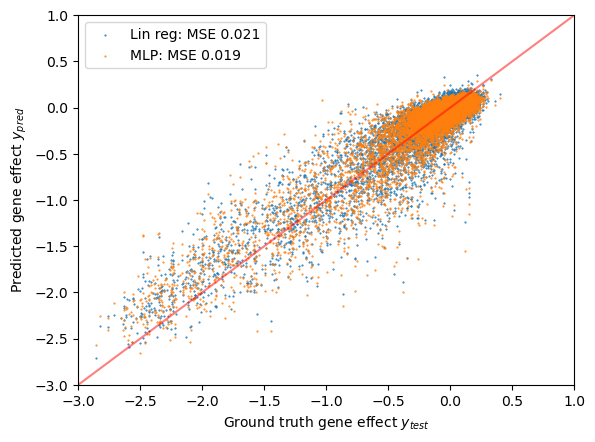

In [289]:
N = 50000
idx = 0
plt.plot([-3,1], [-3, 1], 'r', alpha=.5)
plt.scatter(y_test[idx][:N], y_pred_lin[idx][:N], marker='.', s=1, label=f"Lin reg: MSE {mse_lin:.3f}")
plt.scatter(y_test[idx][:N], y_pred[idx][:N], marker='.', s=1, label=f"MLP: MSE {mse_mlp:.3f}")
plt.xlim(-3,1)
plt.ylim(-3,1)
plt.xlabel("Ground truth gene effect $y_{test}$")
plt.ylabel("Predicted gene effect $y_{pred}$")
plt.legend()
plt.show()

### Train with smoothing

In [290]:
train_start = 100
nb_train = 40
test_start = 500
nb_test = 40

train_cell_lines = list(range(train_start,train_start+nb_train))
X_train = gene_expression.iloc[train_cell_lines].to_numpy()
y_train = gene_effect.iloc[train_cell_lines].to_numpy()

test_cell_lines = list(range(test_start,test_start+nb_test))
X_test = gene_expression.iloc[test_cell_lines].to_numpy()
y_test = gene_effect.iloc[test_cell_lines].to_numpy()

In [313]:
def transform(X,layers, verbose=True):
    x_new = []
    for x_line_idx, x_line in enumerate(X):
        if verbose:
            print(f"line {x_line_idx+1}/{len(X)}")
        cl_expression = x_line
        for layer_idx, layer in enumerate(layers):
            if verbose:
                print(f"    layer {layer_idx+1}/{len(layers)}")
            cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
        x_new.append(cl_expression *1)
    return np.array(x_new)

In [299]:
%%time

layers = [
    {'params':[1,2], 'aggr':'max'},
    {'params':0.5, 'aggr':'add'},
    {'params':[3, 1], 'aggr':'mean', 'normalize':False, 'bias':-2},
]
#layers = [  {'params':0.18, 'aggr':'add'},  ]

X_train_transf = transform(X_train, layers)
X_test_transf = transform(X_test, layers)

line 1/40
    layer 1/3
    layer 2/3
    layer 3/3
line 2/40
    layer 1/3
    layer 2/3
    layer 3/3
line 3/40
    layer 1/3
    layer 2/3
    layer 3/3
line 4/40
    layer 1/3
    layer 2/3
    layer 3/3
line 5/40
    layer 1/3
    layer 2/3
    layer 3/3
line 6/40
    layer 1/3
    layer 2/3
    layer 3/3
line 7/40
    layer 1/3
    layer 2/3
    layer 3/3
line 8/40
    layer 1/3
    layer 2/3
    layer 3/3
line 9/40
    layer 1/3
    layer 2/3
    layer 3/3
line 10/40
    layer 1/3
    layer 2/3
    layer 3/3
line 11/40
    layer 1/3
    layer 2/3
    layer 3/3
line 12/40
    layer 1/3
    layer 2/3
    layer 3/3
line 13/40
    layer 1/3
    layer 2/3
    layer 3/3
line 14/40
    layer 1/3
    layer 2/3
    layer 3/3
line 15/40
    layer 1/3
    layer 2/3
    layer 3/3
line 16/40
    layer 1/3
    layer 2/3
    layer 3/3
line 17/40
    layer 1/3
    layer 2/3
    layer 3/3
line 18/40
    layer 1/3
    layer 2/3
    layer 3/3
line 19/40
    layer 1/3
    layer 2/3
    layer 3/3
li

In [300]:
%%time
reg = LinearRegression().fit(X_train_transf, y_train)

CPU times: user 50.2 s, sys: 8.88 s, total: 59.1 s
Wall time: 44.1 s


In [301]:
y_pred_transf = reg.predict(X_test_transf)
mse_lin_transf = MSE(y_pred_transf,y_test)

print(f"Linear regression with smoothing")
print(f"MSE {mse_lin_transf:.3f}")

Linear regression with smoothing
MSE 0.029


In [302]:
%%time
regr = MLPRegressor(random_state=1, 
                    max_iter=500, 
                    #early_stopping=True,
                    #hidden_layer_sizes=(200,200,200),
                    #activation='logistic',
                   ).fit(X_train_transf, y_train)

CPU times: user 3.82 s, sys: 388 ms, total: 4.2 s
Wall time: 2.69 s


In [303]:
y_pred_transf = regr.predict(X_test_transf)
mse_mlp_transf = MSE(y_pred_transf, y_test)

print(f"Multilayer perceptron with smoothing")
print(f"MSE {mse_mlp_transf:.3f}")

Multilayer perceptron with smoothing
MSE 0.185


### Comparison of them all

In [309]:
print(f"Linear regression without smoothing")
print(f"MSE {mse_lin:.3f}")
print(f"Multilayer perceptron without smoothing")
print(f"MSE {mse_mlp:.3f}")
print(f"Linear regression with smoothing")
print(f"MSE {mse_lin_transf:.3f}")
print(f"Multilayer perceptron with smoothing")
print(f"MSE {mse_mlp_transf:.3f}")

Linear regression without smoothing
MSE 0.022
Multilayer perceptron without smoothing
MSE 0.021
Linear regression with smoothing
MSE 0.029
Multilayer perceptron with smoothing
MSE 0.185


In [323]:
train_start = 100
nb_train = 40
test_start = 500
nb_test = 40

train_cell_lines = list(range(train_start,train_start+nb_train))
X_train = gene_expression.iloc[train_cell_lines].to_numpy()
y_train = gene_effect.iloc[train_cell_lines].to_numpy()

test_cell_lines = list(range(test_start,test_start+nb_test))
X_test = gene_expression.iloc[test_cell_lines].to_numpy()
y_test = gene_effect.iloc[test_cell_lines].to_numpy()

In [324]:
def transform(X,layers, verbose=True):
    x_new = []
    for x_line_idx, x_line in enumerate(X):
        if verbose:
            print(f"line {x_line_idx+1}/{len(X)}")
        cl_expression = x_line
        for layer_idx, layer in enumerate(layers):
            if verbose:
                print(f"    layer {layer_idx+1}/{len(layers)}")
            cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
        x_new.append(cl_expression *1)
    return np.array(x_new)

In [325]:
%%time

layers = [  {'params':0.18, 'aggr':'add'},  ]

X_train_transf = transform(X_train, layers)
X_test_transf = transform(X_test, layers)

line 1/40
    layer 1/1
line 2/40
    layer 1/1
line 3/40
    layer 1/1
line 4/40
    layer 1/1
line 5/40
    layer 1/1
line 6/40
    layer 1/1
line 7/40
    layer 1/1
line 8/40
    layer 1/1
line 9/40
    layer 1/1
line 10/40
    layer 1/1
line 11/40
    layer 1/1
line 12/40
    layer 1/1
line 13/40
    layer 1/1
line 14/40
    layer 1/1
line 15/40
    layer 1/1
line 16/40
    layer 1/1
line 17/40
    layer 1/1
line 18/40
    layer 1/1
line 19/40
    layer 1/1
line 20/40
    layer 1/1
line 21/40
    layer 1/1
line 22/40
    layer 1/1
line 23/40
    layer 1/1
line 24/40
    layer 1/1
line 25/40
    layer 1/1
line 26/40
    layer 1/1
line 27/40
    layer 1/1
line 28/40
    layer 1/1
line 29/40
    layer 1/1
line 30/40
    layer 1/1
line 31/40
    layer 1/1
line 32/40
    layer 1/1
line 33/40
    layer 1/1
line 34/40
    layer 1/1
line 35/40
    layer 1/1
line 36/40
    layer 1/1
line 37/40
    layer 1/1
line 38/40
    layer 1/1
line 39/40
    layer 1/1
line 40/40
    layer 1/1
line 1/40

In [326]:
%%time
reg = LinearRegression().fit(X_train_transf, y_train)

CPU times: user 51 s, sys: 10.7 s, total: 1min 1s
Wall time: 56.1 s


In [327]:
y_pred_transf = reg.predict(X_test_transf)
mse_lin_transf = MSE(y_pred_transf,y_test)

print(f"Linear regression with smoothing")
print(f"MSE {mse_lin_transf:.3f}")

Linear regression with smoothing
MSE 0.024


In [328]:
%%time
regr = MLPRegressor(random_state=1, 
                    max_iter=500, 
                    #early_stopping=True,
                    #hidden_layer_sizes=(200,200,200),
                    #activation='logistic',
                   ).fit(X_train_transf, y_train)

CPU times: user 22.2 s, sys: 2.15 s, total: 24.4 s
Wall time: 16.2 s


In [329]:
y_pred_transf = regr.predict(X_test_transf)
mse_mlp_transf = MSE(y_pred_transf, y_test)

print(f"Multilayer perceptron with smoothing")
print(f"MSE {mse_mlp_transf:.3f}")

Multilayer perceptron with smoothing
MSE 0.023


### Comparison of them all

In [309]:
print(f"Linear regression without smoothing")
print(f"MSE {mse_lin:.3f}")
print(f"Multilayer perceptron without smoothing")
print(f"MSE {mse_mlp:.3f}")
print(f"Linear regression with smoothing")
print(f"MSE {mse_lin_transf:.3f}")
print(f"Multilayer perceptron with smoothing")
print(f"MSE {mse_mlp_transf:.3f}")

Linear regression without smoothing
MSE 0.022
Multilayer perceptron without smoothing
MSE 0.021
Linear regression with smoothing
MSE 0.029
Multilayer perceptron with smoothing
MSE 0.185


### Test something Matthieu

In [112]:
degree_centrality = np.sum(adjacence_matrix > 0, axis=1)

In [114]:
degree_centrality.shape

(16481,)

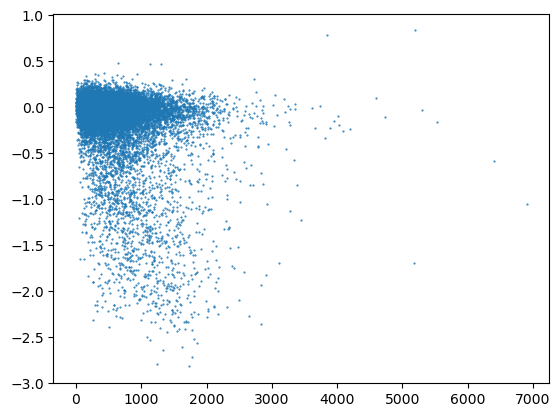

In [172]:
cell_line = 452
cl_gene_effect = gene_effect.iloc[cell_line]
plt.scatter(degree_centrality, cl_gene_effect, marker='.', s=1)
plt.show()

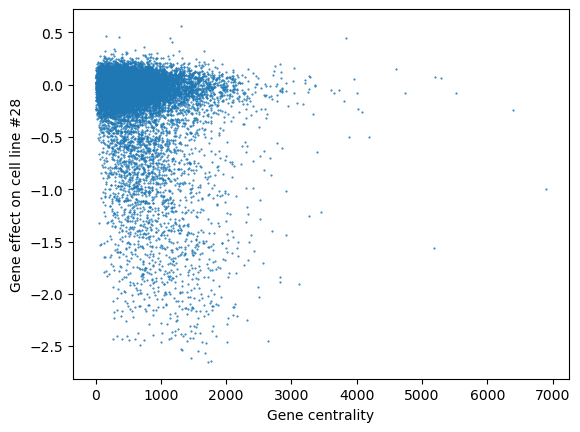

In [173]:
cell_line = 28
cl_gene_effect = gene_effect.iloc[cell_line]
plt.scatter(degree_centrality, cl_gene_effect, marker='.', s=1)
plt.xlabel("Gene centrality")
plt.ylabel(f"Gene effect on cell line #{cell_line}")
plt.show()

## New attempt: multifeatures for linear regression

In [119]:
%%time
degree_centrality = np.sum(adjacence_matrix > 0, axis=1)
norm_factor = np.sum(adjacence_matrix, axis=1)
nb_neighbors = np.sum(adjacence_matrix > 0, axis=1) 

CPU times: user 1.63 s, sys: 1.93 s, total: 3.56 s
Wall time: 5.26 s


In [183]:
def get_features(train_cell_lines):
    X_ge = gene_expression.iloc[train_cell_lines].to_numpy()
    X_DC = degree_centrality[train_cell_lines]  # wut
    
    neighbors = (X_ge @ adjacence_matrix) 
    
    X_add = np.sum(neighbors, axis=1)
    X_add_normed = np.sum(neighbors / norm_factor, axis=1)
    
    X_mean = np.sum(neighbors / nb_neighbors, axis=1)
    X_mean_normed = np.sum(neighbors / (norm_factor * nb_neighbors), axis=1)
    
    X_max = np.max(neighbors, axis=1)
    X_max_normed = np.max(neighbors / norm_factor, axis=1)
    X_max_neigh = np.max(X_ge @ (adjacence_matrix > 0) , axis=1)
    
    X = np.array([X_DC, X_add, X_add_normed, 
                        X_mean, X_mean_normed, X_max, 
                        X_max_normed, X_max_neigh] ).T
    X = np.hstack([X,X_ge])
    return X

In [335]:
gene_expression.shape

(1001, 16481)

In [196]:
%%time
nb_cell_lines = 3 #140
train_cell_lines = list(range(100,100+nb_cell_lines))
X_train = get_features(train_cell_lines)
y_train = gene_effect.iloc[train_cell_lines].to_numpy()

test_cell_lines = list(range(500,500+nb_cell_lines))
X_test = get_features(test_cell_lines)
y_test = gene_effect.iloc[test_cell_lines].to_numpy()

CPU times: user 10 s, sys: 15.3 s, total: 25.4 s
Wall time: 31.1 s


In [197]:
X_train.shape

(3, 16489)

In [198]:
%%time
reg = LinearRegression().fit(X_train, y_train)

CPU times: user 14.3 s, sys: 4.26 s, total: 18.6 s
Wall time: 18.2 s


In [199]:
y_pred_multi = reg.predict(X_test)
mse_multi = MSE(y_pred_multi, y_test)

In [200]:
print(f"Linear regression  with multifeatures")
print(f"MSE {mse_multi:.3f}")

Linear regression  with multifeatures
MSE 0.041


In [201]:
print(f"Linear regression  without anything")
print(f"MSE {mse_lin:.3f}")

Linear regression  without anything
MSE 0.025


In [203]:
print(f"MLP  without anything")
print(f"MSE {mse:.3f}")

MLP  without anything
MSE 0.018


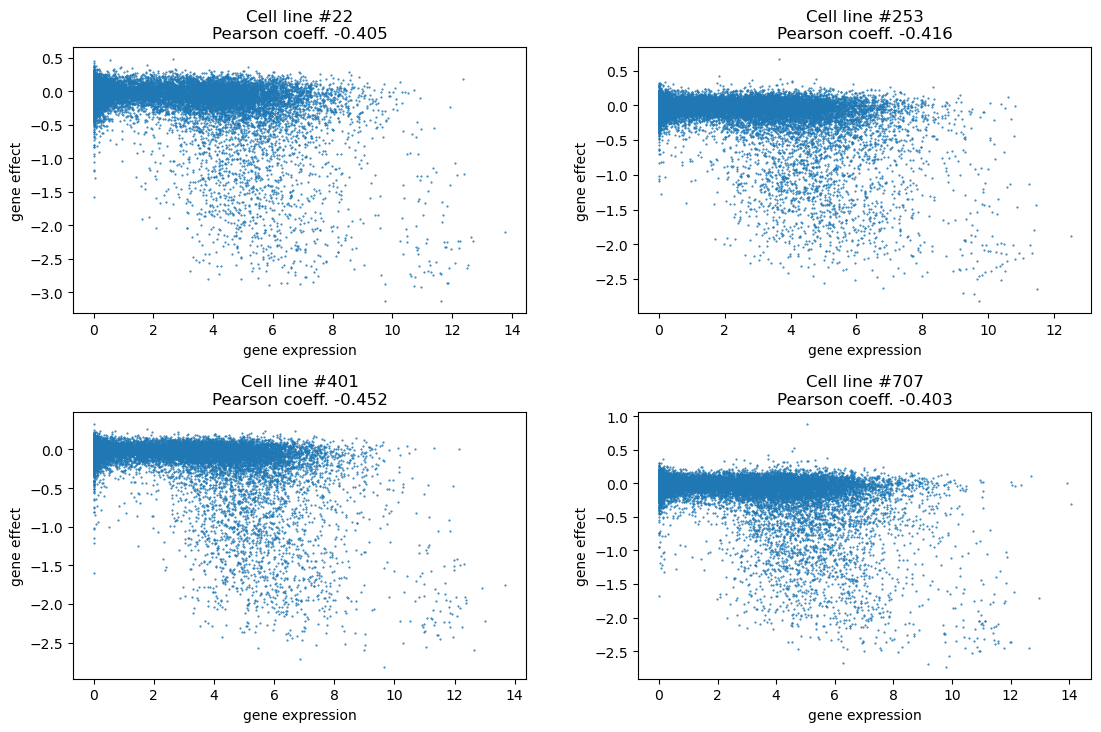

CPU times: user 924 ms, sys: 48.8 ms, total: 973 ms
Wall time: 866 ms


In [186]:
%%time
fig_width = 6
fig_height = 4

nb_i, nb_j = 2,2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

cell_lines = [22, 253, 401, 707]

for i, cell_line in enumerate(cell_lines):
    cl_expression = gene_expression.iloc[cell_line]
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    axs[i].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i].set_title(f"Cell line #{cell_line}\nPearson coeff. {pearson_coeff:.3f}")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

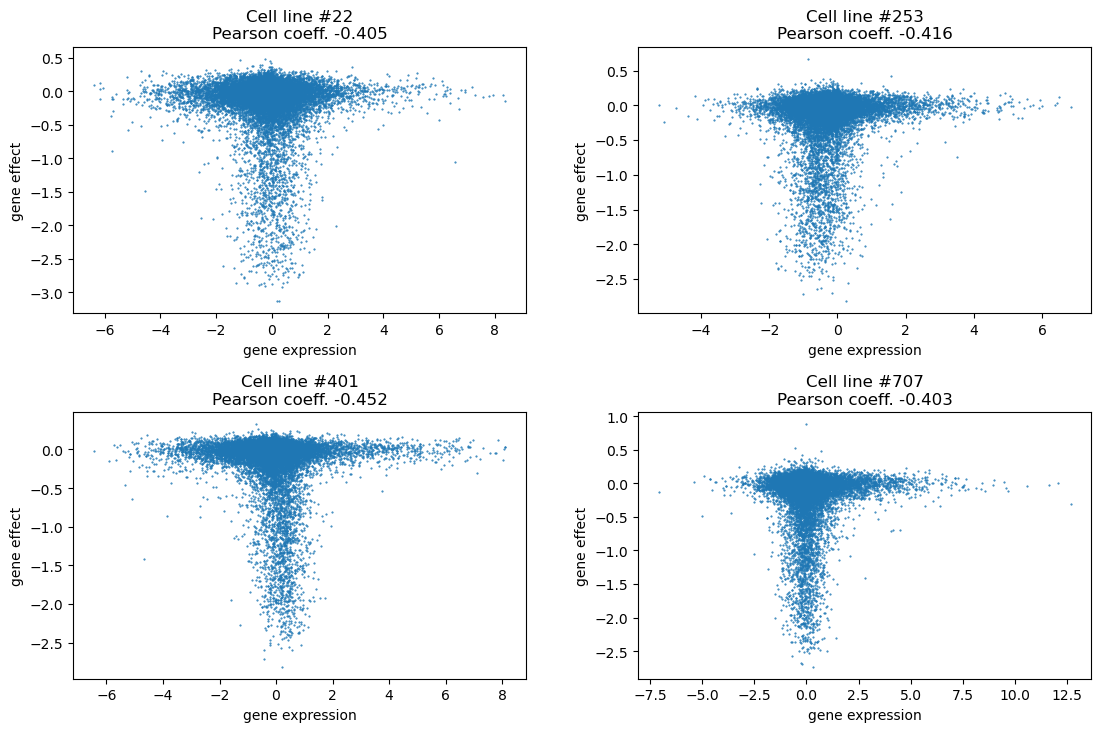

CPU times: user 1.4 s, sys: 1.15 s, total: 2.56 s
Wall time: 5.98 s


In [221]:
%%time
fig_width = 6
fig_height = 4

nb_i, nb_j = 2,2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

cell_lines = [22, 253, 401, 707]

for i, cell_line in enumerate(cell_lines):
    cl_expression = gene_expression.iloc[cell_line]
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    axs[i].scatter(cl_expression - gene_expression_mean, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i].set_title(f"Cell line #{cell_line}\nPearson coeff. {pearson_coeff:.3f}")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()


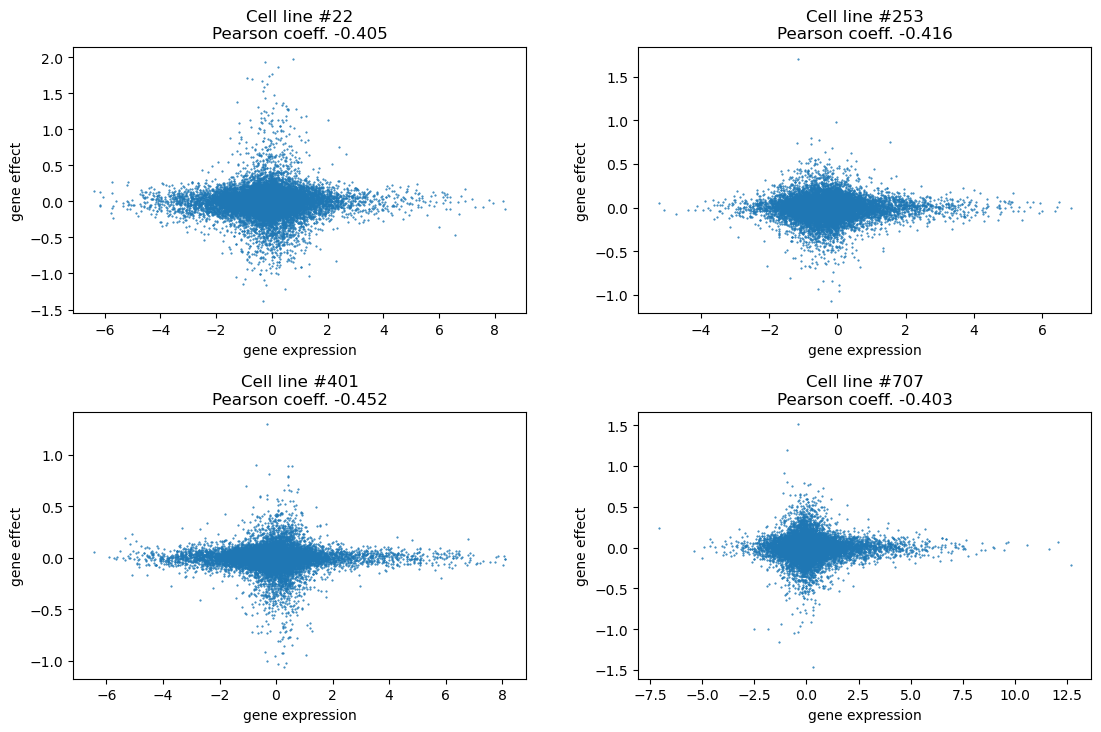

CPU times: user 852 ms, sys: 29.2 ms, total: 882 ms
Wall time: 724 ms


In [197]:
%%time
fig_width = 6
fig_height = 4

nb_i, nb_j = 2,2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

cell_lines = [22, 253, 401, 707]

for i, cell_line in enumerate(cell_lines):
    cl_expression = gene_expression.iloc[cell_line]
    pearson_coeff = pearsonr(cl_expression, gene_effect.iloc[cell_line]).statistic
    axs[i].scatter(cl_expression - gene_expression_mean, gene_effect.iloc[cell_line] - gene_effect_mean, marker='.', s=1)
    axs[i].set_title(f"Cell line #{cell_line}\nPearson coeff. {pearson_coeff:.3f}")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()


In [194]:
gene_expression_mean = gene_expression.mean().to_numpy()

In [196]:
gene_effect_mean = gene_effect.mean().to_numpy()

## Test matthieu centered

### Uncentered

In [217]:
train_cell_lines = list(range(100,140)) #[253, 408, 511]
X_train = gene_expression.iloc[train_cell_lines].to_numpy() 
y_train = gene_effect.iloc[train_cell_lines].to_numpy() 

test_cell_lines = list(range(500,540))
X_test = gene_expression.iloc[test_cell_lines].to_numpy() 
y_test = gene_effect.iloc[test_cell_lines].to_numpy()

In [218]:
%%time
reg = LinearRegression().fit(X_train, y_train)

CPU times: user 50.2 s, sys: 11.7 s, total: 1min 1s
Wall time: 54.7 s


In [219]:
y_pred = reg.predict(X_test)
score = reg.score(X_test, y_test)
mse = MSE(y_pred,y_test)

In [220]:
print(f"Linear regression without smoothing")
print(f"R^2 {score:.3f} | MSE {mse:.3f}")
print(score, mse)

Linear regression without smoothing
R^2 -0.291 | MSE 0.025
-0.2906384611874405 0.02499490694160317


### Centered

In [213]:
train_cell_lines = list(range(100,140)) #[253, 408, 511]
X_train = gene_expression.iloc[train_cell_lines].to_numpy() - gene_expression_mean
y_train = gene_effect.iloc[train_cell_lines].to_numpy()  - gene_effect_mean

test_cell_lines = list(range(500,540))
X_test = gene_expression.iloc[test_cell_lines].to_numpy()  - gene_expression_mean
y_test = gene_effect.iloc[test_cell_lines].to_numpy()  - gene_effect_mean

In [214]:
%%time
reg = LinearRegression().fit(X_train, y_train)

CPU times: user 51.7 s, sys: 11.2 s, total: 1min 2s
Wall time: 51.6 s


In [215]:
y_pred = reg.predict(X_test)
score = reg.score(X_test, y_test)
mse = MSE(y_pred,y_test)

In [216]:
print(f"Linear regression without smoothing")
print(f"R^2 {score:.3f} | MSE {mse:.3f}")
print(score, mse)

Linear regression without smoothing
R^2 -0.291 | MSE 0.025
-0.2906428391871405 0.024994774521195133


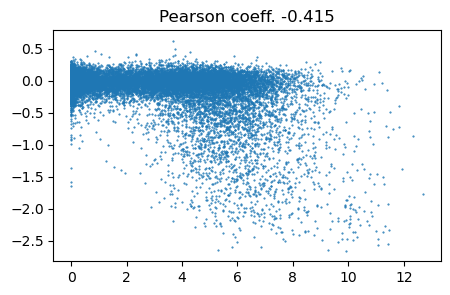

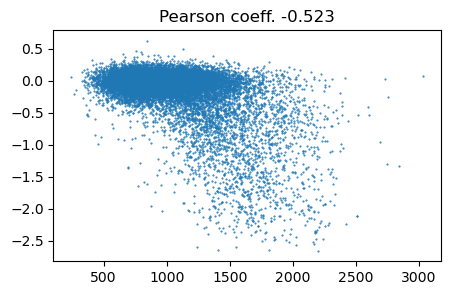

In [163]:
figsize=(5,3)
pearson_coeff = np.mean([pearsonr(x,y).statistic for x,y in zip(X_test, y_test)])
plt.figure(figsize=figsize)
plt.scatter(X_test[idx], y_test[idx], marker='.', s=1)
plt.title(f"Pearson coeff. {pearson_coeff:.3f}")
plt.show()

pearson_coeff = np.mean([pearsonr(x,y).statistic for x,y in zip(X_test_transf, y_test)])
plt.figure(figsize=figsize)
plt.scatter(X_test_transf[idx], y_test[idx], marker='.', s=1)
plt.title(f"Pearson coeff. {pearson_coeff:.3f}")
plt.show()

## LET'S START AGAIN IN A CLEAN MANNER

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
def MSE(x,y):
    return np.mean((x-y)**2)

### Train-test split

In [343]:
%%time
train_cell_lines = 100 #list(range(100,240)) #[253, 408, 511]
X_train = gene_expression.iloc[train_cell_lines].to_numpy().reshape(-1,1)
y_train = gene_effect.iloc[train_cell_lines].to_numpy().reshape(-1,1)

test_cell_lines = 500 #list(range(500,640))
X_test = gene_expression.iloc[test_cell_lines].to_numpy().reshape(-1,1)
y_test = gene_effect.iloc[test_cell_lines].to_numpy().reshape(-1,1)

CPU times: user 972 µs, sys: 513 µs, total: 1.49 ms
Wall time: 3.56 ms


### Train without smoothing

In [344]:
%%time
reg = LinearRegression().fit(X_train, y_train)

CPU times: user 8.1 ms, sys: 3.93 ms, total: 12 ms
Wall time: 14.2 ms


In [345]:
%%time
y_pred = reg.predict(X_test)
score = reg.score(X_test, y_test)
mse = MSE(y_pred, y_test)

CPU times: user 6.35 ms, sys: 2.79 ms, total: 9.13 ms
Wall time: 6.53 ms


In [346]:
print(f"Linear regression without smoothing")
print(f"R^2 {score:.3f} | MSE {mse:.3f}")

Linear regression without smoothing
R^2 0.168 | MSE 0.140


In [347]:
a = reg.coef_[0,0]
b = reg.intercept_[0]

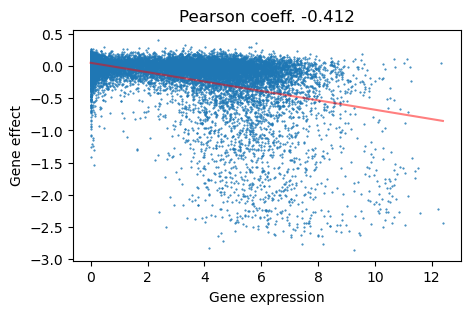

In [348]:
figsize=(5,3)
pearson_coeff = pearsonr(X_test[:,0], y_test[:,0]).statistic
plt.figure(figsize=figsize)
plt.scatter(X_test, y_test, marker='.', s=1)
plt.title(f"Pearson coeff. {pearson_coeff:.3f}")
line = np.array([np.min(X_test), np.max(X_test)])
plt.plot(line, line * a + b, 'r', alpha=0.5)
plt.xlabel("Gene expression")
plt.ylabel("Gene effect")
plt.show()

### Train with smoothing

In [349]:
def transform(X,layers, verbose=True):
    
    cl_expression = X[:,0]
    for layer_idx, layer in enumerate(layers):
        if verbose:
            print(f"    layer {layer_idx+1}/{len(layers)}")
        cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)
        cl_expression = cl_expression.reshape(X.shape[0])
    
    return cl_expression.reshape(X.shape)

In [350]:
%%time

layers = [
    {'params':0.15, 'aggr':'add'},
]


X_train_transf = transform(X_train, layers)

    layer 1/1
CPU times: user 2.21 s, sys: 5.59 s, total: 7.81 s
Wall time: 14.3 s


In [351]:
%%time
reg = LinearRegression().fit(X_train_transf, y_train)

CPU times: user 23.4 ms, sys: 58 ms, total: 81.4 ms
Wall time: 123 ms


In [352]:
%%time
X_test_transf = transform(X_test, layers)

    layer 1/1
CPU times: user 2.16 s, sys: 4.75 s, total: 6.91 s
Wall time: 8.12 s


In [353]:
y_pred_transf = reg.predict(X_test_transf)
score = reg.score(X_test, y_pred_transf)
mse = MSE(y_pred_transf,y_test)

print(f"Linear regression with smoothing")
print(f"R^2 {score:.3f} | MSE {mse:.3f}")

Linear regression with smoothing
R^2 -0.693 | MSE 0.134


In [354]:
a = reg.coef_[0,0]
b = reg.intercept_[0]

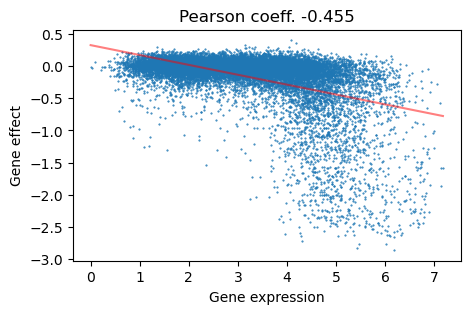

In [355]:
figsize=(5,3)
pearson_coeff = pearsonr(X_test_transf[:,0], y_test[:,0]).statistic
plt.figure(figsize=figsize)
plt.scatter(X_test_transf, y_test, marker='.', s=1)
plt.title(f"Pearson coeff. {pearson_coeff:.3f}")
line = np.array([np.min(X_test_transf), np.max(X_test_transf)])
plt.plot(line, line * a + b, 'r', alpha=0.5)
plt.xlabel("Gene expression")
plt.ylabel("Gene effect")
plt.show()

### Smoothing differently

In [356]:
%%time

layers = [
    {'params':[1,2], 'aggr':'max'},
    {'params':0.5, 'aggr':'add'},
    {'params':[3, 1], 'aggr':'mean', 'normalize':False, 'bias':-2},
]

X_train_transf = transform(X_train, layers)

    layer 1/3
    layer 2/3
    layer 3/3
CPU times: user 8.85 s, sys: 9.59 s, total: 18.4 s
Wall time: 27.7 s


In [357]:
%%time
reg = LinearRegression().fit(X_train_transf, y_train)

CPU times: user 28.9 ms, sys: 162 ms, total: 191 ms
Wall time: 825 ms


In [358]:
%%time
X_test_transf = transform(X_test, layers)

    layer 1/3
    layer 2/3
    layer 3/3
CPU times: user 10.5 s, sys: 16.8 s, total: 27.4 s
Wall time: 47.8 s


In [359]:
y_pred_transf = reg.predict(X_test_transf)
score = reg.score(X_test, y_pred_transf)
mse = MSE(y_pred_transf,y_test)

print(f"Linear regression with smoothing")
print(f"R^2 {score:.3f} | MSE {mse:.3f}")

Linear regression with smoothing
R^2 -8.311 | MSE 0.128


In [360]:
a = reg.coef_[0,0]
b = reg.intercept_[0]

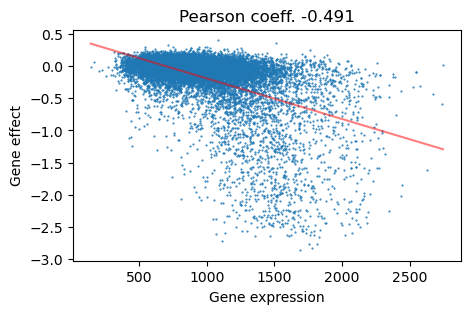

In [361]:
figsize=(5,3)
pearson_coeff = pearsonr(X_test_transf[:,0], y_test[:,0]).statistic
plt.figure(figsize=figsize)
plt.scatter(X_test_transf, y_test, marker='.', s=1)
plt.title(f"Pearson coeff. {pearson_coeff:.3f}")
line = np.array([np.min(X_test_transf), np.max(X_test_transf)])
plt.plot(line, line * a + b, 'r', alpha=0.5)
plt.xlabel("Gene expression")
plt.ylabel("Gene effect")
plt.show()

### Plot of MSE as a function of  smoothing parameter $\lambda$

In [319]:
gene_expression.index[28]

'ACH-000048'

In [316]:
%%time
lambs = [0.01, 0.05, 0.1, 0.15, 0.18, 0.2, 0.22, 0.25, 0.3, 0.5, 0.8, 1]
cell_line = 253

mses = []
for lamb in lambs:
    print(f"lambda {lamb}", end="")
    
    layers = [
        {'params':lamb, 'aggr':'add'},
    ]

    X_train_transf = transform(X_train, layers, verbose=False)
    X_test_transf = transform(X_test, layers, verbose=False)
    reg = LinearRegression().fit(X_train_transf, y_train)
    y_pred_transf = reg.predict(X_test_transf)
    mse = MSE(y_pred_transf,y_test)
    mses.append(mse)

    print(f" | MSE {mse:.3f}")
    a = reg.coef_[0,0]
    b = reg.intercept_[0]

lambda 0.01 | MSE 0.137
lambda 0.05 | MSE 0.136
lambda 0.1 | MSE 0.135
lambda 0.15 | MSE 0.134
lambda 0.18 | MSE 0.134
lambda 0.2 | MSE 0.134
lambda 0.22 | MSE 0.134
lambda 0.25 | MSE 0.134
lambda 0.3 | MSE 0.134
lambda 0.5 | MSE 0.135
lambda 0.8 | MSE 0.138
lambda 1 | MSE 0.140
CPU times: user 51.5 s, sys: 1min 48s, total: 2min 40s
Wall time: 3min 31s


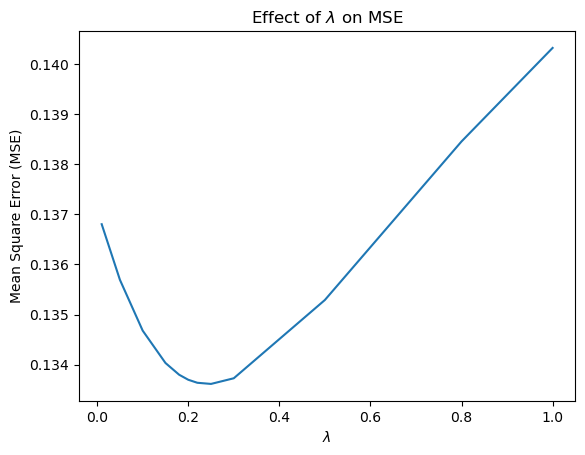

In [317]:
plt.plot(lambs, mses)
plt.xlabel("$\lambda$")
plt.ylabel("Mean Square Error (MSE)")
plt.title('Effect of $\lambda$ on MSE')
plt.show()

$$ \hat y = a X + b$$

$$ \hat y^* = a X^* + b$$


$$ \hat y = A \vec X + \vec b $$

$$ h_i(\vec X) = \sigma(W_i \vec X + \vec b_i)$$

$$ MSE(y,\hat y) =\frac 1 {N_c} \sum_{cell ~ lines} \bigg( \frac 1 {N_g} \sum_{i=1}^{N_g} (y_i - \hat y_i)^2 \bigg) $$

$$ i = 1, \dots N-1$$
q
$$ h_N(\vec X) = W_N \vec X + \vec b_N$$